### Purpose of the Notebook

Create summary graphics demonstrating the "parametric" capabilities developed in sub-folders.

In [1]:
import sys
if 'win' in sys.platform.lower():
    from pathlib import WindowsPath as Path
else:
    from pathlib import PosixPath as Path

PARENT  = Path('../').resolve()
sys.path.append(str(PARENT))

from engineering_models.common_util import ParamterizedLinearModel,setup_axis_default,setup_plotting_format,make_radar_plot
from engineering_models import common_util
from typing import Tuple
import pickle
import numpy as np

setup_plotting_format()

STATE_MODELS = PARENT.joinpath('engineering_models/.model')
RX_MODELS = PARENT.joinpath('recrystallization/.inference')

### Approximating Engineering State Models

Functions for approximating engineering temperature state models

In [2]:
def get_opt_parameter(material_name: str, 
                      material_property: str,
                      xlim: Tuple = (500,1300)):

    """
    given a material, find the parameter "gamma" which optmially 
    represents the material property in the given temperature range
    in an L2 sense.
    """
    sys.path.append(str(STATE_MODELS.parent))
    try:
        with open(STATE_MODELS.joinpath(f'{material_name}_{material_property}.pkl'),'rb') as f:
            material_model = pickle.load(f)  
        
        with open(STATE_MODELS.joinpath(f'{material_property}_parametric.pkl'),'rb') as f:
            parametric_model = pickle.load(f)
    except FileNotFoundError as fnfe:
        raise FileNotFoundError(f"Model for {material_name} not found: {str(fnfe)}")

    gamma = parametric_model.find_gamma(material_model.predict,xlim)
    sys.path.pop()
    return gamma

def get_state_parameter_representation(material_name: str,
                                        xlim: Tuple = (500,1300)):

    """
    get the optimal parametric representation of the material
    from model files
    """
    params = []
    param_names = ['uts','ue','k']
    for param_name in param_names:
        params.append(get_opt_parameter(material_name,param_name,xlim = xlim))
    

    return params

def jmak_model(t: np.ndarray,T:np.ndarray,latent_param: np.ndarray,latent_var: np.ndarray) -> np.ndarray:
    """
    So we can just plug in a point estimate easily
    """
    latent_param = latent_param.reshape([5,2])
    a1,B1,n = latent_var[0]*latent_param[0:3,1] + latent_param[0:3,0]
    a2,B2 = latent_var[1]*latent_param[3:,1] + latent_param[3:,0]

    b = np.exp(a1 + B1/T)
    t_inc = np.exp(a2 + B2/T)
    return 1.0 - np.exp(-b**n*(np.where(t > t_inc, t,t_inc) - t_inc)**n)
    


### State Property Plots

Compared below are the relavant engineering property state functions of temperature, _i.e._ $S_u,\varepsilon_u,k$ and a third, hypothetical material, that is completely specified by 5 parameters, a single parameter for each of the three first properties, and 2 for the last.

This hypothetical material has slightly smaller $S_u$ then the high performance alloy, but much greater than pure W. It has intermediate conductivity and much larger $\varepsilon_u$ than previously seen alloys. Finally, it has enhanced recrystillization resistance, beyond what has been recorded in the literature to date.

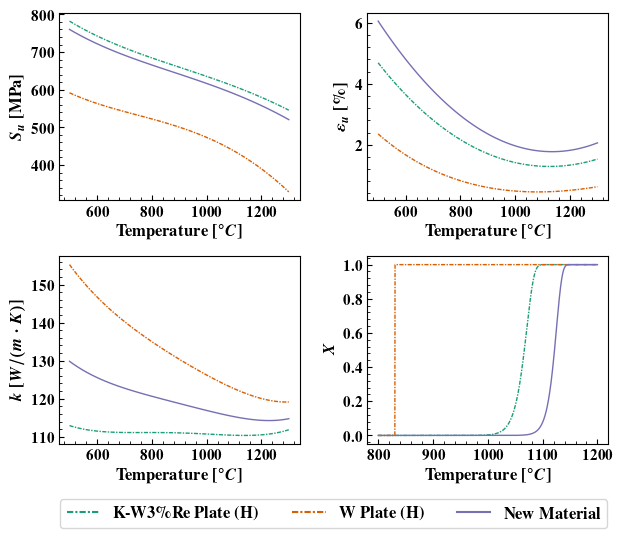

In [24]:
from matplotlib import pyplot as plt

fig,axes = plt.subplot_mosaic("""
                              AB
                              CD
                              EE
                              """,
                              height_ratios= [1,1,0.15],
                              figsize = (6.5,5.5))

axes,legend_ax = np.array([[axes['A'],axes['B']],[axes['C'],axes['D']]]),axes['E']
# S_u, epsilon_u, k
material_name= ['K-W3%Re Plate (H)','W Plate (H)']
material_properties = {'uts': r'$S_u$ \textbf{[MPa]}','ue': r'$\varepsilon_u$ \textbf{[\%]}','k': r'$k$ \textbf{[$W/(m \cdot K)$]'}
material_params = dict.fromkeys(material_name)
material_colors = plt.get_cmap('Dark2')(np.linspace(0,0.35,3))

FANTASY_MATERIAL = [0.8,0.5,0.0,30.,15.0,28,-240]

temperature = np.linspace(500,1300,100)
for j,material in enumerate(material_name): 
    material_params[material] = list(get_state_parameter_representation(material))
    for i,material_property,ax in zip(range(3),material_properties,axes.ravel()):
        with open(STATE_MODELS.joinpath(f'{material_property}_parametric.pkl'),'rb') as f:
            model = pickle.load(f)
        y = model(temperature[:,np.newaxis],material_params[material][i]).squeeze()
        ax.plot(temperature,y,lw = 1,color = material_colors[j],ls = (0, (3, 1, 1, 1)))

for i,ax,material_property in zip(range(3),axes.ravel(),material_properties):
    with open(STATE_MODELS.joinpath(f'{material_property}_parametric.pkl'),'rb') as f:
        model = pickle.load(f)
    y = model(temperature[:,np.newaxis],FANTASY_MATERIAL[i]).squeeze()
    ax.plot(temperature,y,lw = 1,color = material_colors[-1])

for ax,material_property in zip(axes.ravel(),material_properties):
    setup_axis_default(ax)
    ax.set_xlabel(r'\textbf{Temperature [$^\circ C$]}',fontsize = 12)
    ax.set_ylabel(material_properties[material_property],fontsize = 12)


SECONDS_TO_HOURS = 3600.0
HOURS_TO_YEAR = 24.0*365.0
SECONDS_TO_YEAR = SECONDS_TO_HOURS*HOURS_TO_YEAR
temperature = np.linspace(800,1200,1000) + 273.15
for i,material in enumerate(['K-doped 3%Re W','Pure W']):
    with open(RX_MODELS.joinpath(material + '_tpa_map.pkl'),'rb') as f:
        jmak_params = pickle.load(f)['map']
        latent_parameters = jmak_params['latent_param']  
        kbar,tbar = jmak_params['latent_variables']
    
    material_params[material_name[i]].extend([float(kbar),float(tbar)])
    
    Xhat = jmak_model(SECONDS_TO_YEAR*np.ones_like(temperature),temperature,latent_parameters,[kbar,tbar])
    axes[1,1].plot(temperature - 273.15,Xhat,lw = 1,color = material_colors[i],label = material,
                   ls = (0, (3, 1, 1, 1)))


Xhat = jmak_model(SECONDS_TO_YEAR*np.ones_like(temperature),temperature,latent_parameters,FANTASY_MATERIAL[-4:-2])
axes[1,1].plot(temperature - 273.15,Xhat,lw = 1,color = material_colors[-1],label = material)

axes[1,1].set_xlabel(r'\textbf{Temperature [$^\circ C$]}',fontsize = 12)
axes[1,1].set_ylabel(r'$X$',fontsize = 12)
setup_axis_default(axes[1,1])
legend_ax.legend(
    handles = [plt.Line2D([0],[0],color = material_colors[i],ls = (0,(3,1,1,1)),
                          label = r'\textbf{' + material_name.replace('%',r'\%') + '}') \
               for i,material_name in enumerate(material_name)] + [plt.Line2D([0],[0],color = material_colors[-1],label = r'\textbf{New Material}')],
    ncols = 3,fontsize = 12,loc = 'center'
)
legend_ax.axis('off')
t = np.linspace(0,100,100)

material_params['K-W3%Re Plate (H)'].extend([30.2196,-293.489])
material_params['W Plate (H)'].extend([30.2196,-271.761])

fig.tight_layout()
fig.savefig('../.git_images/parametric_representation.svg',bbox_inches = 'tight')


### Radar Plots


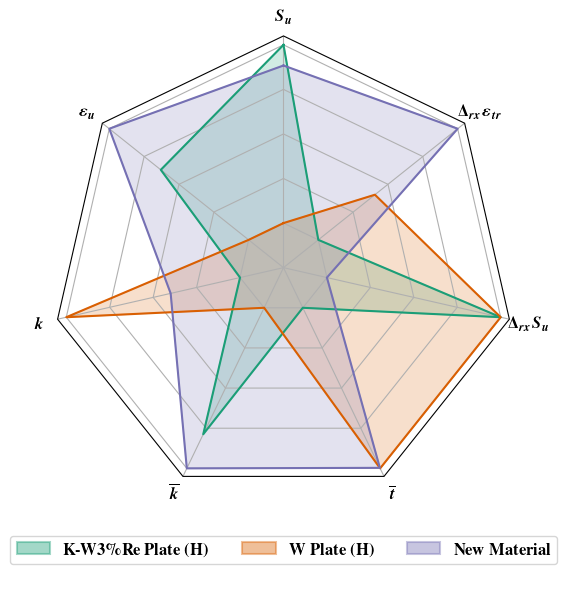

In [ ]:
from matplotlib.patches import Patch

ALPHA = 0.2
theta = make_radar_plot(7,frame = 'polygon')
fig = plt.figure(figsize = (6,6))
axes = fig.subplot_mosaic(
    """
    A
    B
    """,
    per_subplot_kw= {'A': dict(projection = 'radar')},
    height_ratios= [8,1]
)

axes["A"].set_varlabels([r'$S_u$',r'$\varepsilon_u$',r'$k$',r'$\overline{k}$',r'$\overline{t}$',r'$\Delta_{rx} S_u$',r'$\Delta_{rx} \varepsilon_{tr}$'],
                 fontsize = 12)
axes['A'].tick_params('both',labelsize = 12)
props = np.array(list(material_params.values()) + [FANTASY_MATERIAL])


min_props = props.min(axis = 0)
max_props = props.max(axis = 0)
for i,material in enumerate(list(material_params.values()) + [FANTASY_MATERIAL]):
    p = (np.array(material) - min_props)/(max_props- min_props)*0.8 + 0.2
    axes['A'].plot(theta,p,color = material_colors[i])
    axes['A'].fill(theta,p,color = material_colors[i],alpha = ALPHA)

axes['B'].axis('off')   
axes['B'].legend(
    handles = [Patch(facecolor = material_colors[i],alpha = 2*ALPHA, edgecolor = material_colors[i],
                     label = r'\textbf{' + material_name.replace('%',r'\%') + '}',lw = 1.5) \
                for i,material_name in enumerate(material_name)] + \
                    [Patch(facecolor = material_colors[-1],edgecolor = material_colors[i],
                           alpha = 2*ALPHA,label = r'\textbf{New Material}',lw = 1.5)],
fontsize = 12,ncols = 3,loc = 'center'
)
axes['A'].set_yticklabels([])
fig.tight_layout()
fig.savefig('../.git_images/parametric_representation_radar_demo.svg',bbox_inches = 'tight')